# Reservoir computing

Here we try to improve the prediction of model on experimental data by using pre-trained AMNWt. This model is pre-trained on simulated data created by using cobra solver. We use this on two pair of dataset. Fist on e_coli, we use e_coli_core_UB as simulated dataset and iML1515_EXP_UB as experimental dataset. Then on P.putida, we use IJN1463_10_UB as simulated dataset and IJN1463_EXP_UB_Anne.

In [70]:
SAVE_FIGURES = False
data_dir = "../data"

In [71]:
# E_coli
dataset_file_simulated = "/Dataset/e_coli_core_UB.npz"
objective_simulated=['BIOMASS_Ecoli_core_w_GAM']
dataset_file_experimental = "/Dataset/iML1515_EXP_UB.npz"
objective_experimental=['BIOMASS_Ec_iML1515_core_75p37M']
model_file_simulated = "../models/AMNWt_e_coli_core_UB.keras"

drop_out_rate = 0.2

batch_size = 7
epochs = 2000

In [45]:
# P.putida
dataset_file_simulated = "/Dataset/IJN1463_10_UB.npz"
objective_simulated=['BIOMASS_KT2440_WT3']
dataset_file_experimental = "/Dataset/IJN1463_EXP_UB_Anne.npz"
objective_experimental=['BIOMASS_KT2440_WT3']
model_file_simulated = "../models/AMNWt_IJN1463_10_UB.keras"

# no drop out
drop_out_rate = 0

batch_size = 30
epochs = 100

## Load the pre-trained model and simulated dataset information

In [72]:
import tensorflow as tf
from amn.model.aMNWtModel import AMNWtModel, RNNCell

model_class = AMNWtModel
seed = 10
tf.random.set_seed(seed)


model_simulated = model_class(dataset_file=data_dir + dataset_file_simulated, 
                   objective=objective_simulated,
                   timestep=4,
                   hidden_dim=50,
                   verbose=True,
                   )


model_simulated.train_test_split(test_size=0.1, random_state=seed)

# Preprocessing
from amn.tools import MaxScaler
scaler= MaxScaler()
model_simulated.preprocess(scaler)
print(scaler.max)

# Add tree zero column to the Y
model_simulated.preprocessing_for_specific_model()


from amn.tools import custom_loss
AMNWt_model = tf.keras.models.load_model(model_file_simulated, 
                                          custom_objects={"RNNCell":RNNCell,
                                                          "my_mse":custom_loss(model_simulated.S, 
                                                                               model_simulated.P_out,
                                                                               model_simulated.P_in)}
                                          )

print("R2 :", model_simulated.R2(model_simulated.Y_train, AMNWt_model.predict(model_simulated.X_train)))
print("Q2 :", model_simulated.R2(model_simulated.Y_test, AMNWt_model.predict(model_simulated.X_test)))

number of metabolites:  72
filtered measurements size:  1
10.0
R2 : 0.9888228666362848
Q2 : 0.9861056804729627


## Load the experimental data

In [73]:
import tensorflow as tf
from amn.model import AMNWtModel


model_class = AMNWtModel
seed = 10 
# seed = 20
tf.random.set_seed(seed)


print("---------------------------------------- model ----------------------------------------")
model_experimental = model_class(dataset_file=data_dir + dataset_file_experimental, 
                   objective=objective_experimental,
                   timestep=4,
                   hidden_dim=50,
                   verbose=True,
                   )

# Preprocessing
model_experimental.train_test_split(test_size=0.1, random_state=seed)
from amn.tools import MaxScaler
scaler= MaxScaler()
model_experimental.preprocess(scaler)
print(scaler.max)

# Add tree zero column to the Y
model_experimental.preprocessing_for_specific_model()

---------------------------------------- model ----------------------------------------
number of metabolites:  1080
filtered measurements size:  1
1


## Add a layer to old pre-trained model and fix model weights

In [74]:

from tensorflow.keras import Model, Input, layers

input_size_exp = model_experimental.X.shape[1]
input_size_sim = model_simulated.X.shape[1]


sub_model = AMNWt_model
sub_model.trainable = False
drop_out = layers.Dropout(drop_out_rate, input_shape=(input_size_sim,))
layer = layers.Dense(input_size_sim,activation='relu')

inputs = Input((input_size_exp))
x = layer(drop_out(inputs))
y = sub_model(x)
new_model = Model(inputs=inputs, 
                  outputs=y)
new_model.compile(optimizer='adam',
              loss=custom_loss(model_simulated.S, model_simulated.P_out, model_simulated.P_in),
              metrics=None)

## Train/test on experimental data

In [75]:
# Fit on experimental dataset
history = new_model.fit(model_experimental.X_train, model_experimental.Y_train, epochs=epochs, batch_size=batch_size, verbose=0)

R_2 = model_simulated.R2(model_experimental.Y_train, new_model.predict(model_experimental.X_train))
Q_2 = model_simulated.R2(model_experimental.Y_test, new_model.predict(model_experimental.X_test))
print("R2 :", R_2)
print("Q2 :", Q_2)

R2 : 0.5420535394196715
Q2 : 0.5341304242842286


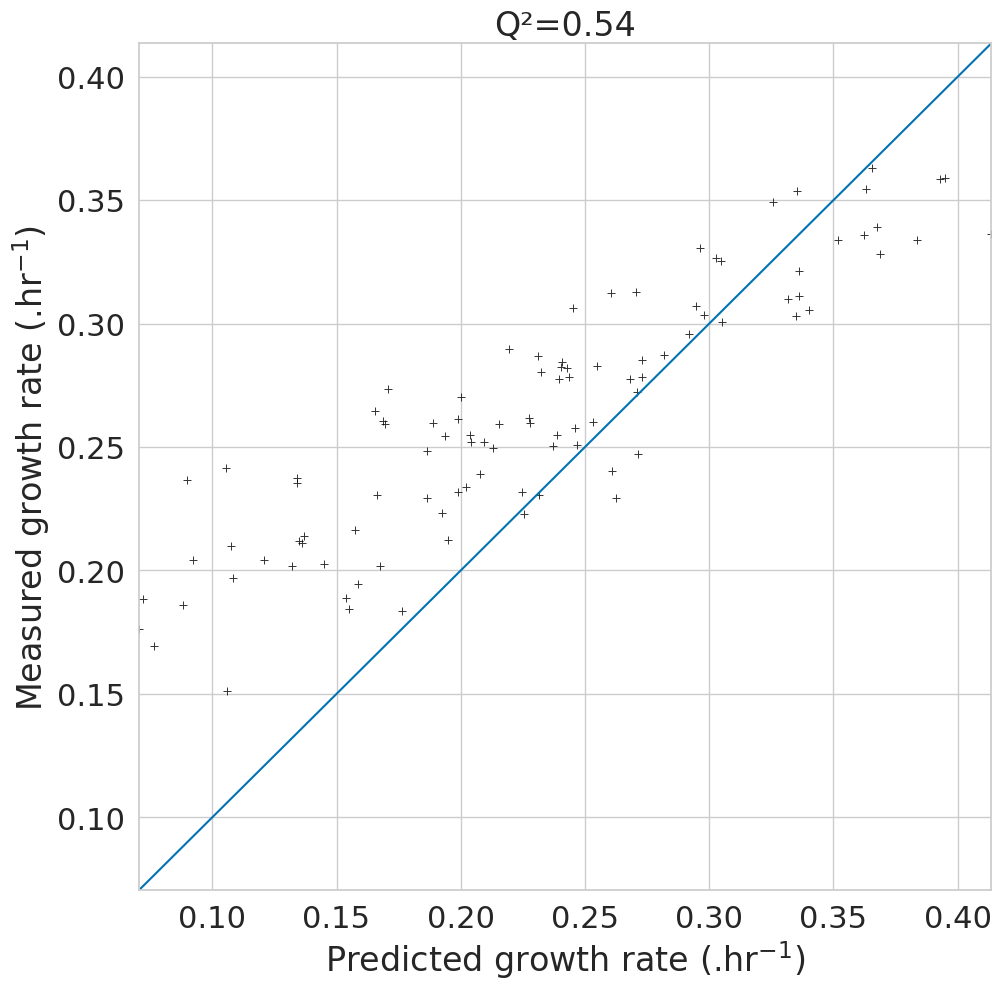

In [76]:
from amn.tools import plot_regression
import numpy as np

TRUE = model_experimental.Y_train[:,0]

pred =  new_model.predict(model_experimental.X_train)
P_out     = tf.convert_to_tensor(np.float32(model_simulated.P_out))   
PRED = tf.linalg.matmul(pred[:,:model_simulated.S.shape[1]], tf.transpose(P_out)) 

if SAVE_FIGURES:
    figure_file = "Figure/e_coli_reservoir_AMNWt_train.png"
else:
    figure_file = None

plot_regression(PRED, 
                TRUE, 
                "Measured growth rate (."+ r'$\mathregular{hr^{-1}}$' +")",
                "Predicted growth rate (."+ r'$\mathregular{hr^{-1}}$' +")",
                "Q²="+str(round(R_2, 2)),
                figure_file)

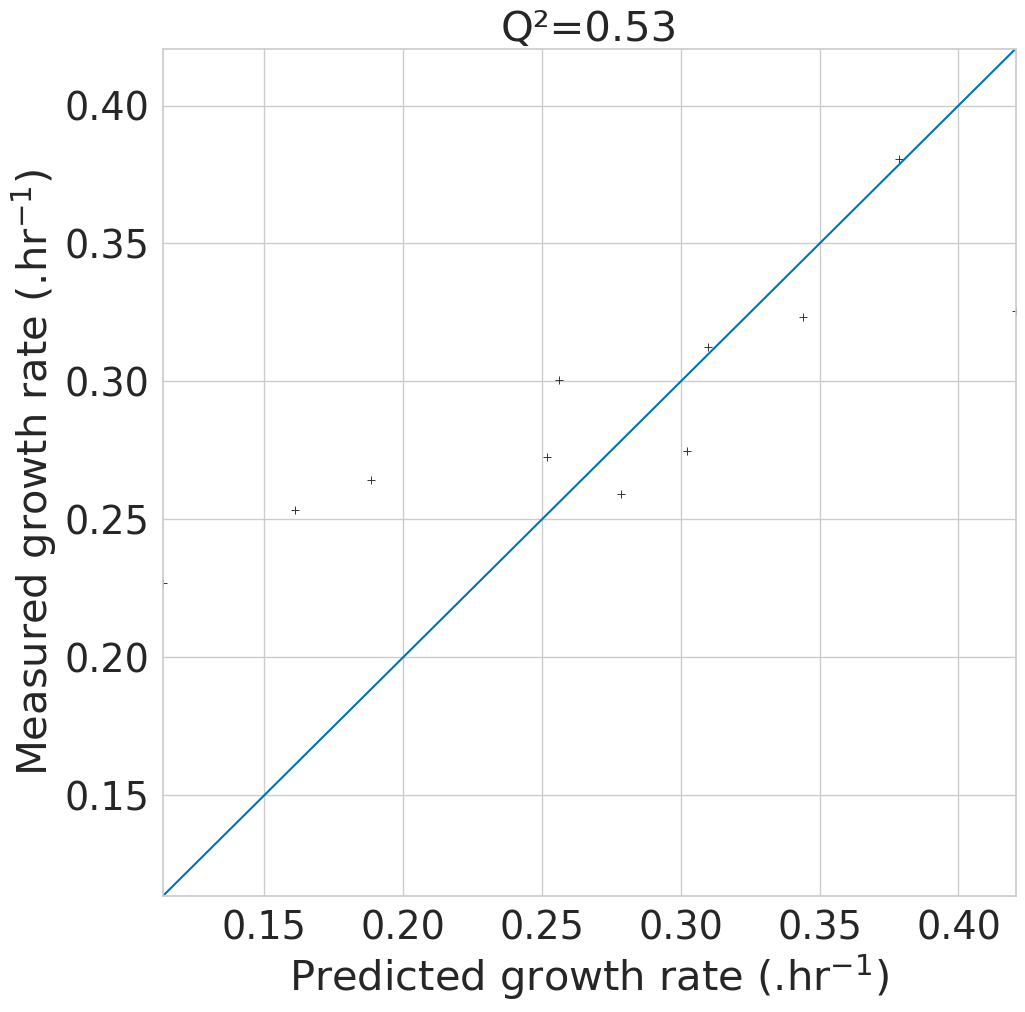

In [77]:
from amn.tools import plot_regression
import numpy as np

TRUE = model_experimental.Y_test[:,0]

pred =  new_model.predict(model_experimental.X_test)
P_out     = tf.convert_to_tensor(np.float32(model_simulated.P_out))   
PRED = tf.linalg.matmul(pred[:,:model_simulated.S.shape[1]], tf.transpose(P_out)) 

if SAVE_FIGURES:
    figure_file = "Figure/e_coli_reservoir_AMNWt_test.png"
else:
    figure_file = None

plot_regression(PRED, 
                TRUE, 
                "Measured growth rate (."+ r'$\mathregular{hr^{-1}}$' +")",
                "Predicted growth rate (."+ r'$\mathregular{hr^{-1}}$' +")",
                "Q²="+str(round(Q_2, 2)),
                figure_file)
                # "Figure/biolog_iML1515_EXP_UB_AMNWt_" + str(epoch) +"_"+ str(batch_size) +"_regression.png")

## On all experimental dataset

Since the result depends on the train/test splitting we try to get the score on all the dataset.

In [78]:
import numpy as np
scaler= MaxScaler()

X = scaler.fit_transform(model_experimental.X)
Y = np.concatenate((model_experimental.Y, np.zeros((len(model_experimental.Y),3))), axis=1)

# Shuffle dataset
idx = np.arange(len(X))
np.random.shuffle(idx)
X = X[idx]
Y = Y[idx]

In [79]:
from tensorflow.keras.layers import Dropout
 
# reset the model
inputs = Input((input_size_exp))

drop_out = Dropout(drop_out_rate, input_shape=(input_size_sim,))

layer = layers.Dense(input_size_sim,activation='relu')

x = layer(drop_out(inputs))
# x = layer(inputs)
y = sub_model(x)
new_model = Model(inputs=inputs, 
                  outputs=y)
new_model.compile(optimizer='adam',
              loss=custom_loss(model_simulated.S, model_simulated.P_out, model_simulated.P_in),
              metrics=None)
history = new_model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=0)
R_2 = model_simulated.R2(Y, new_model.predict(X))
print("R2 :", R_2)

R2 : 0.5991624507231672


In [85]:

TRUE = Y[:,0]

pred =  new_model.predict(X)
P_out     = tf.convert_to_tensor(np.float32(model_simulated.P_out))   
PRED = tf.linalg.matmul(pred[:,:model_simulated.S.shape[1]], tf.transpose(P_out)) 

In [86]:
pred.shape

(110, 174)

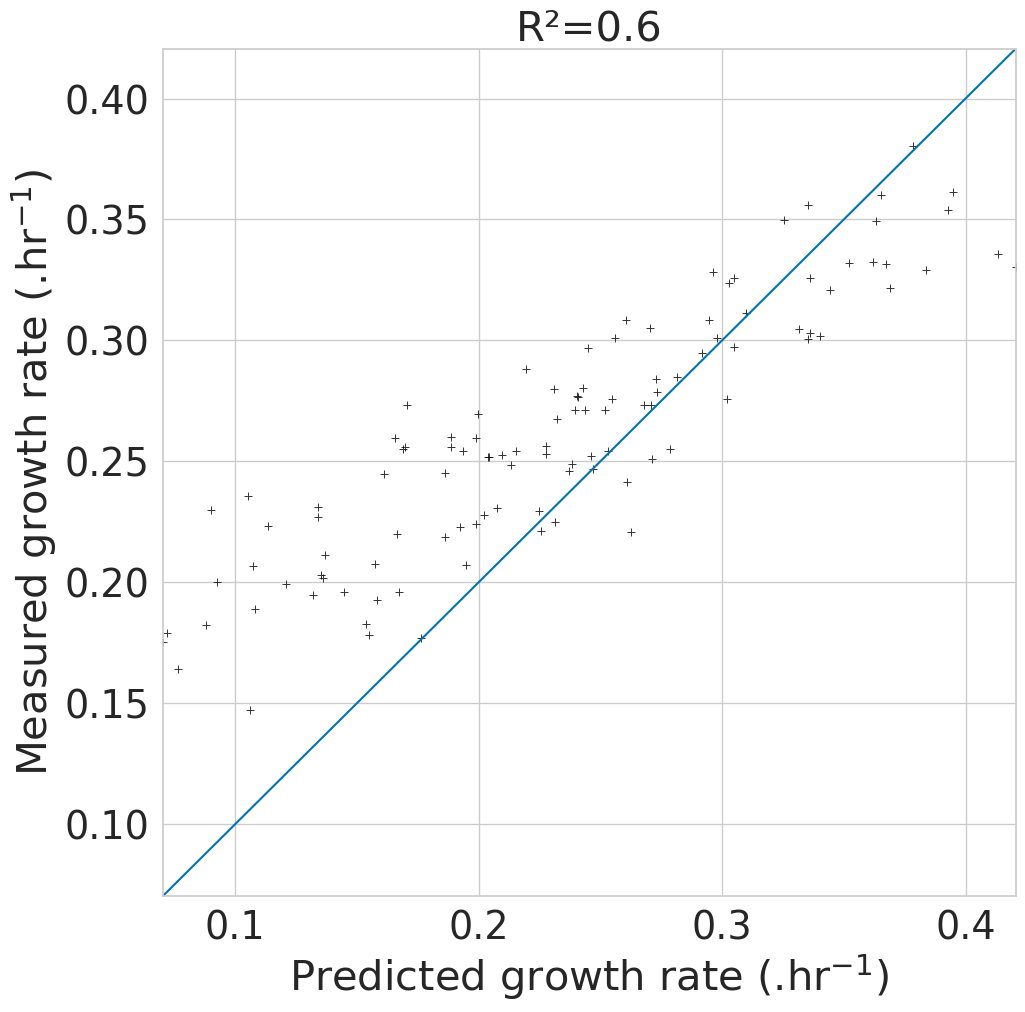

In [87]:
from amn.tools import plot_regression
plot_regression(PRED, 
                TRUE, 
                "Measured growth rate (."+ r'$\mathregular{hr^{-1}}$' +")",
                "Predicted growth rate (."+ r'$\mathregular{hr^{-1}}$' +")",
                "R²="+str(round(R_2, 2)),)

## Classification

This part is for P.putida only; the dataset is label 0 or 1 for growth no-growth so we threshold the result of trained regression to get classification result. We also give accuracy result for the different sub-dataset corresponding to the carbon and nitrogen source replacement.

In [88]:
PRED_ = np.array(PRED)
max = PRED_.max()
percentage = 0.5
PRED_t = PRED_ >= max*percentage
PRED_tresholded = PRED_t.astype(int)

In [89]:
from amn.tools import plot_classification
plot_classification(PRED, TRUE)

ValueError: continuous format is not supported

In [90]:
from sklearn.metrics import accuracy_score
all_accuracy = accuracy_score(PRED_tresholded, TRUE)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [91]:
nitrogen = X[:,22] == 0 
carbon = X[:,15] ==0

nitrogen_index = [i for (i, bool) in enumerate(nitrogen) if bool]
carbon_index = [i for (i, bool) in enumerate(carbon) if bool]

X[carbon_index].shape
Y[carbon_index].shape

carbon_accuracy = accuracy_score(PRED_tresholded[carbon_index] , TRUE[carbon_index])
nitrogen_accuracy = accuracy_score(PRED_tresholded[nitrogen_index] , TRUE[nitrogen_index])

IndexError: index 0 is out of bounds for axis 0 with size 0

All accuracy : 0.97
Carbon : 0.95
Nitrogen : 0.98


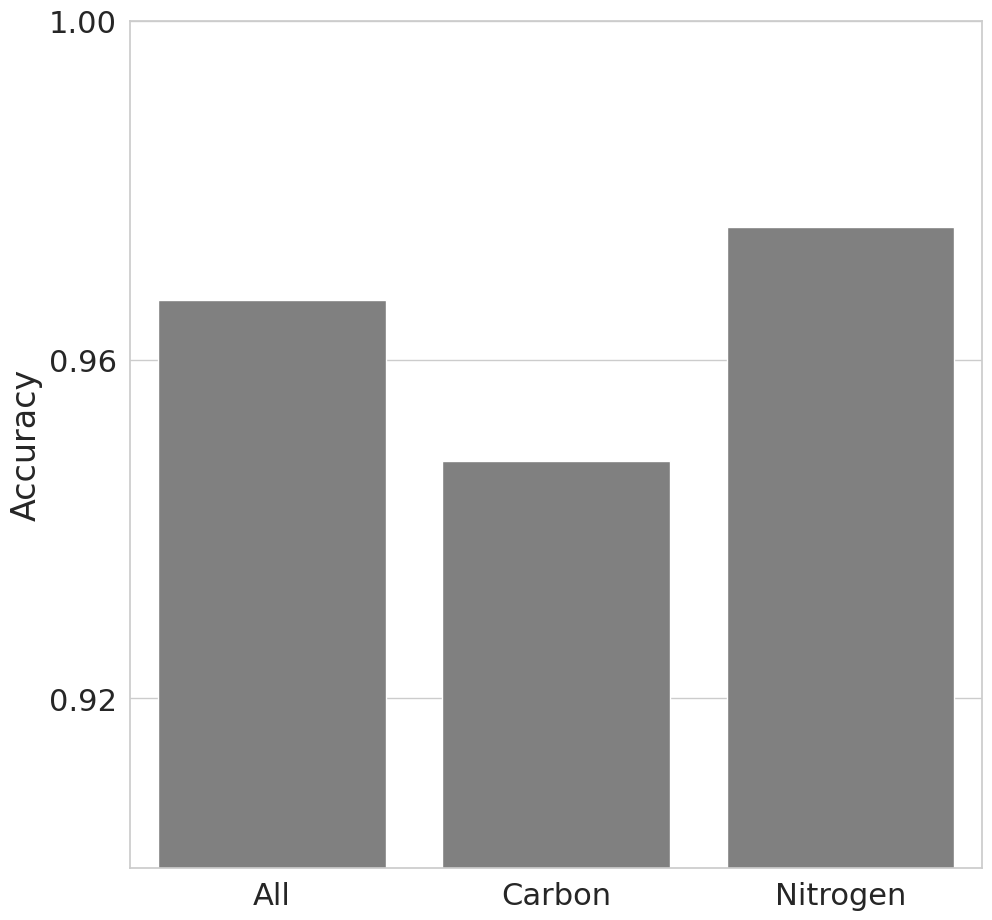

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt



condition = ["All", "Carbon", "Nitrogen"]
acc_fit_AMN = [all_accuracy, carbon_accuracy, nitrogen_accuracy]
# acc_fit_AMN = (all_accuracy, carbon_accuracy, nitrogen_accuracy)

print("All accuracy : %.2f\nCarbon : %.2f\nNitrogen : %.2f" %(all_accuracy, carbon_accuracy, nitrogen_accuracy))

sns.set_theme(style='whitegrid', font='arial', font_scale=2, palette='colorblind')
sns.barplot(x=condition, y=acc_fit_AMN, color="grey")
# plt.errorbar(x = condition, y = acc_fit_AMN, yerr=std_fit_AMN, fmt='none', c='orange', capsize = 2)
plt.yticks([0.92, 0.96, 1.00])
plt.ylabel("Accuracy")
plt.ylim(0.9, 1)
# plt.savefig("Figures/Fig5E."+FORMAT, format=FORMAT, dpi=800, bbox_inches = 'tight')
if SAVE_FIGURES:
    plt.savefig("Figure/Putida_accuracy_all_carbon_nitrogen", format="png", dpi=800, bbox_inches = 'tight')
plt.show()
plt.close('all')

## The dataset splitting have a big influence on result

We compute Q² score for different train/test split. Since the dataset is not large the seed for splitting have an influence on the score. The drop out helps a lot.

In [93]:
for i in range(10):
   seed = 10+i
   print("seed : ",seed)
   tf.random.set_seed(seed)
   dataset_file = "/Dataset/iML1515_EXP_UB.npz"
   objective=['BIOMASS_Ec_iML1515_core_75p37M']
   uptake_max_index=None

   print("---------------------------------------- model ----------------------------------------")
   model_experimental = model_class(dataset_file= data_dir + dataset_file, 
                      objective=objective,
                      timestep=4,
                   #    n_hidden=1, 
                      hidden_dim=50,
                     #  epochs=50, 
                      verbose=True,
                     #  batch_size=7,
                      uptake_max_index = uptake_max_index)
   
   # Preprocessing
   model_experimental.train_test_split(test_size=0.1, random_state=seed)
   # if RESCALE:
   from amn.tools import MaxScaler
   scaler= MaxScaler()
   model_simulated.preprocess(scaler)
   model_experimental.preprocessing_for_specific_model()


   inputs = Input((input_size_exp))

   drop_out = Dropout(drop_out_rate, input_shape=(input_size_sim,))

   layer = layers.Dense(input_size_sim,activation='relu')

   x = layer(drop_out(inputs))
   # x = layer(inputs)
   y = sub_model(x)
   new_model = Model(inputs=inputs, 
                     outputs=y)
   new_model.compile(optimizer='adam',
                 loss=custom_loss(model_simulated.S, model_simulated.P_out, model_simulated.P_in),
                 metrics=None)

   
   history = new_model.fit(model_experimental.X_train, model_experimental.Y_train, epochs=1500, batch_size=7, verbose=0)

   R_2 = model_simulated.R2(model_experimental.Y_train, new_model.predict(model_experimental.X_train))
   Q_2 = model_simulated.R2(model_experimental.Y_test, new_model.predict(model_experimental.X_test))
   print("R2 :", R_2)
   print("Q2 :", Q_2)



seed :  10
---------------------------------------- model ----------------------------------------
number of metabolites:  1080
filtered measurements size:  1
R2 : 0.6024652699476472
Q2 : 0.5583445524698994
seed :  11
---------------------------------------- model ----------------------------------------
number of metabolites:  1080
filtered measurements size:  1
R2 : 0.566047572553368
Q2 : 0.5192452739307574
seed :  12
---------------------------------------- model ----------------------------------------
number of metabolites:  1080
filtered measurements size:  1
R2 : 0.571592288092331
Q2 : 0.28746950073531596
seed :  13
---------------------------------------- model ----------------------------------------
number of metabolites:  1080
filtered measurements size:  1
R2 : 0.5627398856724206
Q2 : 0.7067346123889007
seed :  14
---------------------------------------- model ----------------------------------------
number of metabolites:  1080
filtered measurements size:  1
R2 : 0.5247679

KeyboardInterrupt: 